In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


In [3]:
batch_size = 4   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [4]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
%matplotlib inline

dataset_path  = '.'
anns_file_path = dataset_path + '/' + 'copy_paste.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 50419
Number of images: 2616


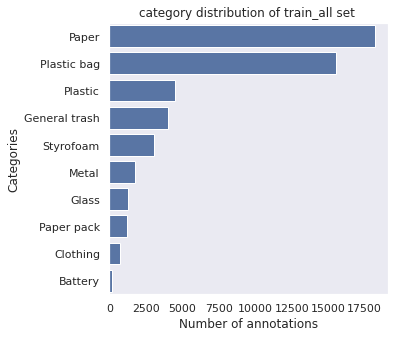

In [32]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [33]:
display(df)

,Categories,Number of annotations
1,Paper,18227
7,Plastic bag,15507
5,Plastic,4508
0,General trash,4009
6,Styrofoam,3048
3,Metal,1757
4,Glass,1257
2,Paper pack,1178
9,Clothing,722
8,Battery,206


In [20]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [21]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,4009.0
2,Paper,18227.0
3,Paper pack,1178.0
4,Metal,1757.0
5,Glass,1257.0
6,Plastic,4508.0
7,Styrofoam,3048.0
8,Plastic bag,15507.0
9,Battery,206.0


In [22]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path,'output','JPEGImages', image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [23]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/copy_paste.json'


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])


# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=collate_fn
                                           )


loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [24]:
class_colormap = pd.read_csv("../../baseline_code/class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [25]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper pack', 3}]
tensor([[0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        ...,
        [0, 0, 0,  ..., 3, 3, 0],
        [0, 0, 0,  ..., 3, 3, 0],
        [0, 0, 0,  ..., 3, 3, 0]], dtype=torch.int8)


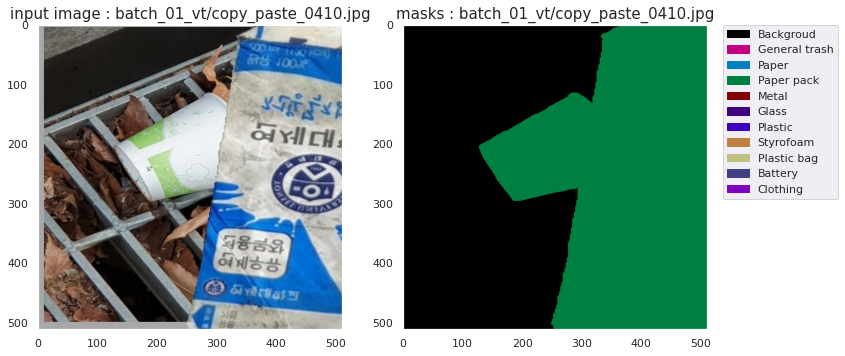

In [26]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

# variable for legend
category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                         edgecolor=webcolors.rgb_to_hex(rgb), 
                         label=category) for category, rgb in category_and_rgb]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(
    temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

print(temp_masks[0])

ax2.imshow(label_to_color_image(np.array(temp_masks[0])))
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.show()